<a href="https://colab.research.google.com/github/AfnanAbdul/TuringLens/blob/main/notebooks/RoBERTa_RAID_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating RoBERTa-LoRA AI Text Detector on RAID Abstract Domain

## Overview
This notebook evaluates the performance of our fine-tuned RoBERTa model with LoRA (Low-Rank Adaptation) on the RAID (Robust AI-generated text Detection) dataset, specifically focusing on the academic abstracts domain.

https://github.com/liamdugan/raid


In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Load the model we trained (RoBERTa LoRA fine-tuned) and tokenizer
model_path = "/content/drive/MyDrive/Colab Notebooks/LLMs_project/TuringLens/results/roberta-lora-ai-detector"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Filter the RAID train data to focus only on the abstracts domain:

In [4]:
from raid.utils import load_data

# For non-adversarial data
train_noadv_df = load_data(split="train", include_adversarial=False)
abstracts_noadv_df = train_noadv_df[train_noadv_df['domain'] == 'abstracts']

100%|██████████| 802M/802M [00:19<00:00, 41.4MB/s]


In [5]:
print(f"Total non-adversarial abstracts: {len(abstracts_noadv_df)}")

Total non-adversarial abstracts: 61810


In [6]:
print(f"Dataset shape: {train_noadv_df.shape}")
print(f"Column names: {train_noadv_df.columns.tolist()}")
print(f"Label distribution: {train_noadv_df['model'].value_counts()}")

Dataset shape: (467985, 11)
Column names: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation']
Label distribution: model
llama-chat      53484
mpt             53484
mpt-chat        53484
gpt2            53484
mistral-chat    53484
mistral         53484
cohere          26742
gpt3            26742
gpt4            26742
chatgpt         26742
cohere-chat     26742
human           13371
Name: count, dtype: int64


This is large! sampling the dataset for now...

Let's have the human label make up 50% of the sample data, and the remaining 50% distributed equally among AI models:

In [27]:
# how many AI models we have (excluding human)
models = abstracts_noadv_df['model'].unique()
ai_models = [m for m in models if m != 'human']
num_ai_models = len(ai_models)

# total sample size and allocate half to human samples
total_sample_size = 3532
human_sample_size = total_sample_size // 2  # Half for human
ai_sample_per_model = (total_sample_size - human_sample_size) // num_ai_models  # Equal distribution for AI models

abstracts_noadv_sample = pd.DataFrame()

# Sample human examples
human_df = abstracts_noadv_df[abstracts_noadv_df['model'] == 'human']
if len(human_df) > human_sample_size:
    human_sample = human_df.sample(human_sample_size, random_state=42)
else:
    human_sample = human_df  # Take all human examples if fewer than needed
    print(f"Warning: Only {len(human_df)} human examples available")

abstracts_noadv_sample = pd.concat([abstracts_noadv_sample, human_sample], ignore_index=True)

# Sample from each AI model type
for model in ai_models:
    model_df = abstracts_noadv_df[abstracts_noadv_df['model'] == model]
    if len(model_df) > ai_sample_per_model:
        model_sample = model_df.sample(ai_sample_per_model, random_state=42)
    else:
        model_sample = model_df  # Take all if there are fewer than needed
        print(f"Warning: Only {len(model_df)} examples available for model {model}")

    abstracts_noadv_sample = pd.concat([abstracts_noadv_sample, model_sample], ignore_index=True)

# Shuffle the final sample
abstracts_noadv_sample = abstracts_noadv_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original non-adversarial abstracts: {len(abstracts_noadv_df)}")
print(f"Sampled non-adversarial abstracts: {len(abstracts_noadv_sample)}")
print(f"Model distribution in sample:")
model_counts = abstracts_noadv_sample['model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(abstracts_noadv_sample)) * 100
    print(f"  {model}: {count} ({percentage:.1f}%)")

Original non-adversarial abstracts: 61810
Sampled non-adversarial abstracts: 3526
Model distribution in sample:
  human: 1766 (50.1%)
  gpt2: 160 (4.5%)
  cohere-chat: 160 (4.5%)
  gpt3: 160 (4.5%)
  llama-chat: 160 (4.5%)
  mpt-chat: 160 (4.5%)
  cohere: 160 (4.5%)
  gpt4: 160 (4.5%)
  mistral: 160 (4.5%)
  mistral-chat: 160 (4.5%)
  chatgpt: 160 (4.5%)
  mpt: 160 (4.5%)


In [28]:
def predict_on_dataframe(df, batch_size=16):
    texts = df['generation'].tolist()
    results = []

    # Check for GPU availability and move model to device
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Move model to GPU
        model.cuda()
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    # Process data in batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # Move inputs to device
        if device.type == 'cuda':
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.softmax(outputs.logits, dim=1)
            ai_scores = predictions[:, 1].cpu().tolist()  # Probability of AI-generated

        results.extend(ai_scores)

        if i % (batch_size * 10) == 0:
            print(f"Processed {i}/{len(texts)} examples")

    return results

In [29]:
# Create true labels (1 for AI, 0 for human)
def get_true_labels(df):
    return [1 if row['model'] != 'human' else 0 for _, row in df.iterrows()]

Running evaluation on the sampled non-adversarial abstracts:

In [32]:
print("\n--- Evaluating on non-adversarial abstracts sample ---")
noadv_predictions = predict_on_dataframe(abstracts_noadv_sample)
noadv_true_labels = get_true_labels(abstracts_noadv_sample)


--- Evaluating on non-adversarial abstracts sample ---
Using device: cuda
Processed 0/3526 examples
Processed 160/3526 examples
Processed 320/3526 examples
Processed 480/3526 examples
Processed 640/3526 examples
Processed 800/3526 examples
Processed 960/3526 examples
Processed 1120/3526 examples
Processed 1280/3526 examples
Processed 1440/3526 examples
Processed 1600/3526 examples
Processed 1760/3526 examples
Processed 1920/3526 examples
Processed 2080/3526 examples
Processed 2240/3526 examples
Processed 2400/3526 examples
Processed 2560/3526 examples
Processed 2720/3526 examples
Processed 2880/3526 examples
Processed 3040/3526 examples
Processed 3200/3526 examples
Processed 3360/3526 examples
Processed 3520/3526 examples


In [33]:
# Calculate metrics for non-adversarial data
noadv_binary_preds = [1 if score > 0.5 else 0 for score in noadv_predictions]
noadv_accuracy = accuracy_score(noadv_true_labels, noadv_binary_preds)
noadv_precision = precision_score(noadv_true_labels, noadv_binary_preds, zero_division=0)
noadv_recall = recall_score(noadv_true_labels, noadv_binary_preds, zero_division=0)
noadv_f1 = f1_score(noadv_true_labels, noadv_binary_preds, zero_division=0)

print(f"Non-Adversarial Results:")
print(f"accuracy: {noadv_accuracy:.4f}")
print(f"precision: {noadv_precision:.4f}")
print(f"recall: {noadv_recall:.4f}")
print(f"f1: {noadv_f1:.4f}")

Non-Adversarial Results:
accuracy: 0.5701
precision: 0.5383
recall: 0.9733
f1: 0.6932


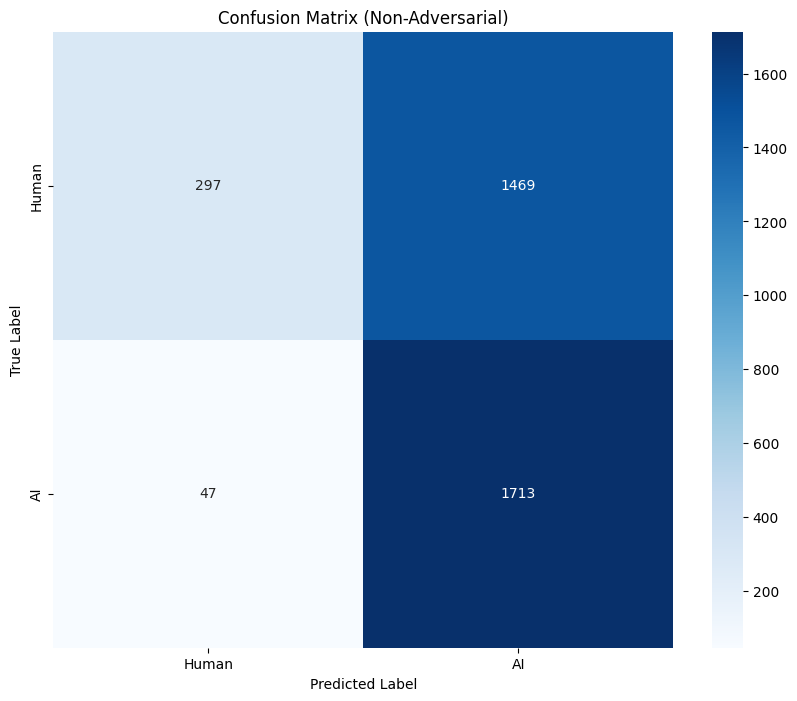

In [34]:
# Generate and display confusion matrix for non-adversarial data
class_names = ["Human", "AI"]
cm_noadv = confusion_matrix(noadv_true_labels, noadv_binary_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_noadv, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Non-Adversarial)')
plt.savefig("roberta_lora_noadv_confusion_matrix.png")
plt.show()

In [35]:
# Human = class 0, AI = class 1
correct_human = cm_noadv[0][0]  # True negative
incorrect_human = cm_noadv[0][1]  # False positive
correct_ai = cm_noadv[1][1]  # True positive
incorrect_ai = cm_noadv[1][0]  # False negative

results_table = pd.DataFrame({
    "Class": ["Human", "AI"],
    "Correct Predictions": [correct_human, correct_ai],
    "Misclassifications": [incorrect_human, incorrect_ai]
})

print("\nClassification Results:")
display(results_table)

print(f"\nHuman Detection Accuracy: {correct_human / (correct_human + incorrect_human):.4f}")
print(f"AI Detection Accuracy: {correct_ai / (correct_ai + incorrect_ai):.4f}")
print(f"Overall Accuracy: {(correct_human + correct_ai) / (correct_human + incorrect_human + correct_ai + incorrect_ai):.4f}")


Classification Results:


,Class,Correct Predictions,Misclassifications
0,Human,297,1469
1,AI,1713,47



Human Detection Accuracy: 0.1682
AI Detection Accuracy: 0.9733
Overall Accuracy: 0.5701


In [36]:
# Performance by AI model analysis
print("\nPerformance by Model Type:")

model_performance = {}

for model_name in abstracts_noadv_sample['model'].unique():
    # Skip if there are no examples of this model in the dataset
    if model_name not in abstracts_noadv_sample['model'].values:
        continue

    model_indices = abstracts_noadv_sample[abstracts_noadv_sample['model'] == model_name].index

    model_preds = [noadv_binary_preds[list(abstracts_noadv_sample.index).index(idx)] for idx in model_indices]
    model_true = [noadv_true_labels[list(abstracts_noadv_sample.index).index(idx)] for idx in model_indices]

    model_acc = accuracy_score(model_true, model_preds)

    model_performance[model_name] = {"accuracy": model_acc, "count": len(model_indices)}

model_df = pd.DataFrame.from_dict(model_performance, orient='index')
model_df = model_df.sort_values("accuracy", ascending=False)

display(model_df)


Performance by Model Type:


,accuracy,count
gpt3,1.000000,160
cohere-chat,1.000000,160
cohere,1.000000,160
llama-chat,1.000000,160
chatgpt,1.000000,160
mistral-chat,1.000000,160
gpt4,1.000000,160
mpt-chat,0.993750,160
gpt2,0.987500,160
mistral,0.968750,160


Citation

In [ ]:
@inproceedings{dugan-etal-2024-raid,
    title = "{RAID}: A Shared Benchmark for Robust Evaluation of Machine-Generated Text Detectors",
    author = "Dugan, Liam  and
      Hwang, Alyssa  and
      Trhl{\'\i}k, Filip  and
      Zhu, Andrew  and
      Ludan, Josh Magnus  and
      Xu, Hainiu  and
      Ippolito, Daphne  and
      Callison-Burch, Chris",
    booktitle = "Proceedings of the 62nd Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)",
    month = aug,
    year = "2024",
    address = "Bangkok, Thailand",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2024.acl-long.674",
    pages = "12463--12492",
}